In [23]:
#pip install gtsam
#****** Test Script to test GTSAM - python installation ******#

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
from transforms3d.euler import mat2euler, euler2mat
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
from mpl_toolkits.mplot3d import Axes3D
import time
import cv2
import gtsam

In [25]:
dataset = 20

with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts - [FR, F L, RR, RL] format
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images


In [26]:
encoder_freq = 40 
diameter = 0.254 
tpr = 360 # ticks per revolution
mpt = 0.0022 # meters per tic
lidar_fov = 270 # degree 
lidar_max_range = 30 # meter
lidar_sample_num = 1081 # Each LiDAR scan contains 1081 measured range values.
# The depth camera is located at (0.18, 0.005, 0.36) m with respect to the robot center and 
# has orientation with roll 0 rad, pitch 0.36 rad, and yaw 0.021 rad.
kinect_loc = np.array([0.18, 0.005, 0.36])
kinect_rot = np.array([0, 0.36, 0.021])
intrinsic_K = np.array([[585.05, 0, 242.94], [0, 585.05, 315.84], [0,0,1]])
lidar_position = np.array([300/2, 0 , 514.35])/ 1000
log_trust_occupancy_grid = 1

In [31]:
def depth_conversion(d, i, j):
    dd = -0.00304 * d + 3.31 
    depth = 1.03 / dd
    rgbi = (526.37 * i + 19276 - 7877.07 * dd) / 585.051
    rgbj = (526.37 * j + 16662) / 585.051
    return depth, rgbi, rgbj

def find_nearest(array, x):
    absolute_diff = np.abs(array - x)
    index = np.argmin(absolute_diff)  
    return index

def read_canonical_model(model_name):
    model_fname = os.path.join('./icp_warm_up/data', model_name, 'model.mat')
    model = sio.loadmat(model_fname)
    cano_pc = model['Mdata'].T / 1000.0 # convert to meter
    return cano_pc

def load_pc(model_name, id):
    pc_fname = os.path.join('./icp_warm_up/data', model_name, '%d.npy' % id)
    pc = np.load(pc_fname)
    return pc

def visualize_icp_result(source_pc, target_pc, pose):
    source_pcd = o3d.geometry.PointCloud()
    source_pcd.points = o3d.utility.Vector3dVector(source_pc.reshape(-1, 3))
    source_pcd.paint_uniform_color([0, 0, 1])
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(target_pc.reshape(-1, 3))
    target_pcd.paint_uniform_color([1, 0, 0])
    source_pcd.transform(pose)
    o3d.visualization.draw_geometries([source_pcd, target_pcd])

def find_best_pose(source, target):
    assert source.shape == target.shape, 'error'
    centroid_source = np.mean(source, axis=0, keepdims=True)
    centered_source = source - centroid_source
    centroid_target = np.mean(target, axis=0, keepdims=True)
    centered_target = target - centroid_target
    Q = centered_target.T @ centered_source
    U, S, Vt = np.linalg.svd(Q)
    R = U @ Vt
    S = np.ones(3)
    S[2] = np.linalg.det(R)
    R = U @ np.diag(S) @ Vt
    P = centroid_target.T - R @ centroid_source.T
    T = np.identity(4)
    T[:3, :3] = R
    T[:3, 3] = P.T
    return T, R, P


def ipc_alg(source, target, neigh, R0, P0, max_iter=1000, tolerance=1e-6):
    P = P0
    R = R0 
    error_hist = -1
    for i in range(max_iter):
        shifted_source = R @ source.T + P
        distances, indices = neigh.kneighbors(shifted_source.T, return_distance=True)
        mean_dist = np.mean(distances**2)
        if np.abs(error_hist - mean_dist) < tolerance:
            break
        error_hist = mean_dist
        target_selected = target[indices[:,0]]
        T, R, P = find_best_pose(source, target_selected)
        P = P.reshape((3, 1))
    #print('last iteration:', i)
    return T, R, P

def bresenham2D(sx, sy, ex, ey):
    '''
    Bresenham's ray tracing algorithm in 2D.
    Inputs:
      (sx, sy)	start point of ray
      (ex, ey)	end point of ray
    '''
    sx = int(round(sx))
    sy = int(round(sy))
    ex = int(round(ex))
    ey = int(round(ey))
    dx = abs(ex-sx)
    dy = abs(ey-sy)
    steep = abs(dy)>abs(dx)
    if steep:
        dx,dy = dy,dx # swap 

    if dy == 0:
        q = np.zeros((dx+1,1))
        q = np.int32(q)
    else:
        q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
    if steep:
        if sy <= ey:
            y = np.arange(sy,ey+1)
        else:
            y = np.arange(sy,ey-1,-1)
        if sx <= ex:
            x = sx + np.cumsum(q)
        else:
            x = sx - np.cumsum(q)
    else:
        if sx <= ex:
            x = np.arange(sx,ex+1)
        else:
            x = np.arange(sx,ex-1,-1)
        if sy <= ey:
            y = sy + np.cumsum(q)
        else:
            y = sy - np.cumsum(q)
    return np.vstack((x,y))

# Encoder and IMU odometry

In [32]:
robot_state_arr = np.zeros((3, encoder_counts.shape[1])) # change the initial if needed

for i in range(1, encoder_counts.shape[1]):
    tau_t = encoder_stamps[i]
    delta_tau = encoder_stamps[i] - encoder_stamps[i-1]
    best_index_imu = find_nearest(imu_stamps,tau_t)
    best_w = imu_angular_velocity[-1, best_index_imu]
    v_t = np.mean(encoder_counts[:,i]) * mpt / delta_tau
    delta_state = np.zeros(3)
    delta_state[0] = v_t * np.sinc(best_w * delta_tau / (2 * np.pi)) * np.cos(robot_state_arr[2, i-1] + best_w * delta_tau / 2)
    delta_state[1] = v_t * np.sinc(best_w * delta_tau / (2 * np.pi)) * np.sin(robot_state_arr[2, i-1] + best_w * delta_tau / 2)
    delta_state[2] = best_w
    robot_state_arr[:, i] = robot_state_arr[:, i-1] + delta_tau * delta_state

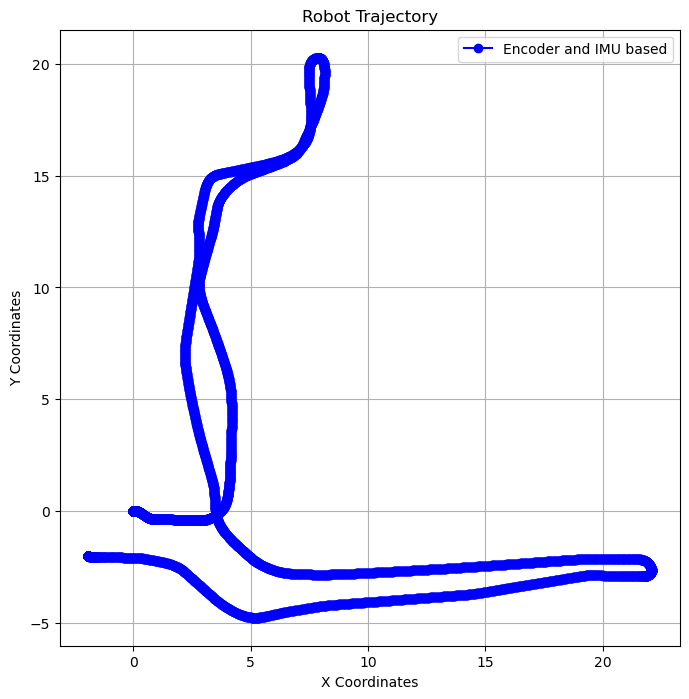

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(robot_state_arr[0,:], robot_state_arr[1,:], marker='o', linestyle='-', color='b')
plt.title('Robot Trajectory')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.legend(['Encoder and IMU based'])
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Trajectory_Encoder_IMU.png')
plt.show()

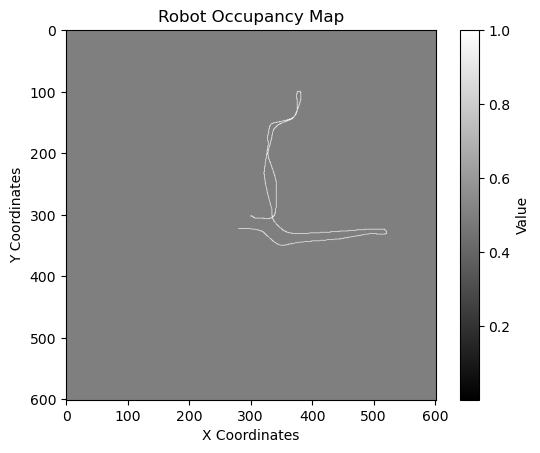

In [34]:
# init MAP
MAP = {}
MAP['res']   = 0.1 #meters
MAP['xmin']  = -30  #meters
MAP['ymin']  = -30
MAP['xmax']  =  30
MAP['ymax']  =  30 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8

# convert from meters to cells
xis = np.ceil((robot_state_arr[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
yis = np.ceil((robot_state_arr[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

# for i in range(xis.shape[0]):
#     MAP['map'][MAP['sizey'] - yis[i], xis[i]] = 1

for i in range(xis.shape[0]-1):
    points = bresenham2D(xis[i], yis[i], xis[i+1], yis[i+1])
    MAP['map'][MAP['sizey'] - points[1], points[0]] += 1

MAP['map'][0,0] = -10
plt.imshow(1/(1+np.exp(-MAP['map'])), cmap="gray");# interpolation='nearest')
plt.colorbar(label='Value')  # Add color bar for reference
plt.title('Robot Occupancy Map')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.grid(False) 
plt.show()

# Point-cloud registration via iterative closest point (ICP)

## 1. Warm-up

In [35]:
obj_name = 'drill' # 'drill' # drill or liq_container
num_pc = 4 # number of point clouds
source_pc = read_canonical_model(obj_name)

In [36]:
data_0 = load_pc(obj_name, 0)
data_1 = load_pc(obj_name, 1)
data_2 = load_pc(obj_name, 2)
data_3 = load_pc(obj_name, 3)

In [37]:
obj_name = 'drill' # 'drill' # drill or liq_container
num_pc = 4 # number of point clouds
source_pc = read_canonical_model(obj_name)
data_0 = load_pc(obj_name, 0)
data_1 = load_pc(obj_name, 1)
data_2 = load_pc(obj_name, 2)
data_3 = load_pc(obj_name, 3)
for source in [data_0, data_1, data_2, data_3]:
    # source = data_0
    centroid_source = np.mean(source, axis=0, keepdims=True)
    centered_source = source - centroid_source
    target = source_pc
    centroid_target = np.mean(target, axis=0, keepdims=True)
    visualize_icp_result(source, target, np.eye(4))
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(target)
    best_yaw = None
    best_mse = None
    best_P = None
    yaw_sample_num = 360
    
    for i in range(yaw_sample_num):
        yaw_sample = (2 * np.pi) * (i-yaw_sample_num//2) / yaw_sample_num
        R = np.array([
            [np.cos(yaw_sample), -np.sin(yaw_sample), 0],
            [np.sin(yaw_sample), np.cos(yaw_sample), 0],
            [0, 0, 1]
        ])
        P = centroid_target.T - R @ centroid_source.T
        shifted_source = R @ source.T + P
        distances, _ = neigh.kneighbors(shifted_source.T, return_distance=True)
        mse_dist = np.mean(distances**2)
        if best_mse == None or best_mse > mse_dist:
            best_mse = mse_dist
            best_yaw = yaw_sample
            best_P = P
            
    print('Best yaw:', best_yaw)
    print('Best mse:', best_mse)
    R0 = np.array([
            [np.cos(best_yaw), -np.sin(best_yaw), 0],
            [np.sin(best_yaw), np.cos(best_yaw), 0],
            [0, 0, 1]
        ])
    P0 = best_P
    T0 = np.identity(4)
    T0[:3, :3] = R0
    T0[:3, 3] = P0.T
    visualize_icp_result(source, target, T0)
    best_T, best_R, best_P = ipc_alg(source, target, neigh, R0, P0)
    visualize_icp_result(source, target, best_T)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -1.1519173063162575
Best mse: 0.00038810544200038115
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -1.8151424220741028
Best mse: 0.0003982022283555698
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -2.007128639793479
Best mse: 0.00032412388541388587
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find se

In [ ]:
obj_name = 'liq_container'
num_pc = 4 # number of point clouds
source_pc = read_canonical_model(obj_name)
data_0 = load_pc(obj_name, 0)
data_1 = load_pc(obj_name, 1)
data_2 = load_pc(obj_name, 2)
data_3 = load_pc(obj_name, 3)
for source in [data_0, data_1, data_2, data_3]:
    # source = data_0
    centroid_source = np.mean(source, axis=0, keepdims=True)
    centered_source = source - centroid_source
    target = source_pc
    centroid_target = np.mean(target, axis=0, keepdims=True)
    visualize_icp_result(source, target, np.eye(4))
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(target)
    best_yaw = None
    best_mse = None
    best_P = None
    yaw_sample_num = 360
    
    for i in range(yaw_sample_num):
        yaw_sample = (2 * np.pi) * (i-yaw_sample_num//2) / yaw_sample_num
        R = np.array([
            [np.cos(yaw_sample), -np.sin(yaw_sample), 0],
            [np.sin(yaw_sample), np.cos(yaw_sample), 0],
            [0, 0, 1]
        ])
        P = centroid_target.T - R @ centroid_source.T
        shifted_source = R @ source.T + P
        distances, _ = neigh.kneighbors(shifted_source.T, return_distance=True)
        mse_dist = np.mean(distances**2)
        if best_mse == None or best_mse > mse_dist:
            best_mse = mse_dist
            best_yaw = yaw_sample
            best_P = P
            
    print('Best yaw:', best_yaw)
    print('Best mse:', best_mse)
    R0 = np.array([
            [np.cos(best_yaw), -np.sin(best_yaw), 0],
            [np.sin(best_yaw), np.cos(best_yaw), 0],
            [0, 0, 1]
        ])
    P0 = best_P
    T0 = np.identity(4)
    T0[:3, :3] = R0
    T0[:3, 3] = P0.T
    visualize_icp_result(source, target, T0)
    best_T, best_R, best_P = ipc_alg(source, target, neigh, R0, P0)
    visualize_icp_result(source, target, best_T)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -3.036872898470133
Best mse: 0.0005915761678527595
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -3.0892327760299634
Best mse: 0.000583515896427408
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -2.792526803190927
Best mse: 0.0007122447405741032
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Best yaw: -3.12413936106985
Best mse: 0.00060051948456055

## Scan Matching

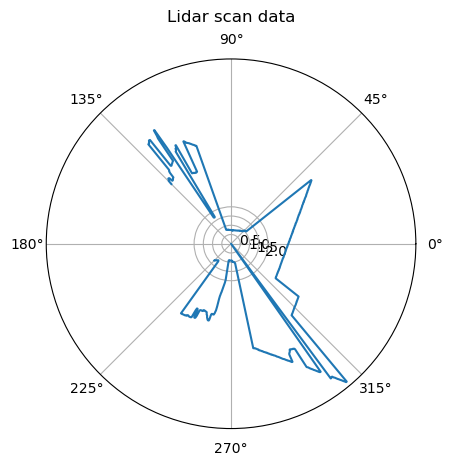

In [8]:
def show_lidar():
  angles = np.arange(-135,135.25,0.25)*np.pi/180.0
  ranges = np.load("test_ranges.npy")
  plt.figure()
  ax = plt.subplot(111, projection='polar')
  ax.plot(angles, ranges)
  ax.set_rmax(10)
  ax.set_rticks([0.5, 1, 1.5, 2])  # fewer radial ticks
  ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
  ax.grid(True)
  ax.set_title("Lidar scan data", va='bottom')
  plt.show()
    
show_lidar()

In [9]:
def convert_lidar_coordinate(lidar_arr):
    angles = np.linspace(lidar_angle_min, lidar_angle_max, 1081).reshape(1,-1)
    selected_indices = ((lidar_arr >= lidar_range_min) & (lidar_arr <= lidar_range_max)).reshape(1,-1)
    #print(selected_indices)
    x = np.cos(angles) * lidar_arr
    x = x[selected_indices].reshape(1,-1)
    y = np.sin(angles) * lidar_arr
    y = y[selected_indices].reshape(1,-1)
    z = np.zeros_like(x)
    out = np.concatenate([x, y, z], axis=0)
    return out

def create_yaw_rotation(yaw):
    R = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    return R

def convert_lidar_robot_frame(index, state_arr, encoder_stamps, lidar_stamps, lidar_position):
    assert index >= 0, 'index should be bigger than 0'
    state = state_arr[:, index]
    tau_t = encoder_stamps[index]
    best_index_lidar = find_nearest(lidar_stamps, tau_t)
    sample_lidar = lidar_ranges[:, best_index_lidar]
    lidar_cor = convert_lidar_coordinate(sample_lidar)
    lidar_cor_robot = lidar_cor + lidar_position.reshape(3,1)
    return state, lidar_cor_robot

In [10]:
LiDAR_robot_state_arr = robot_state_arr.copy()
for index in range(1, LiDAR_robot_state_arr.shape[1]):
    new_state, new_lidar_cor_robot = convert_lidar_robot_frame(index, robot_state_arr, encoder_stamps, lidar_stamps, lidar_position)
    prev_state, prev_lidar_cor_robot = convert_lidar_robot_frame(index-1, robot_state_arr, encoder_stamps, lidar_stamps, lidar_position)
    prev_state_2, prev_lidar_cor_robot_2 = convert_lidar_robot_frame(index-1, LiDAR_robot_state_arr, encoder_stamps, lidar_stamps, lidar_position)    
    relative_R = create_yaw_rotation(new_state[-1] - prev_state[-1])
    relative_P = create_yaw_rotation(prev_state[-1]).T @ np.array([[new_state[0] - prev_state[0]],
                                                                  [new_state[1] - prev_state[1]],
                                                                  [0]])
    neigh = NearestNeighbors(n_neighbors=1)
    target = prev_lidar_cor_robot.T
    source = new_lidar_cor_robot.T
    neigh.fit(target)
    _, best_R, best_P = ipc_alg(source, target, neigh, R0=relative_R, P0=relative_P, max_iter=1000, tolerance=1e-6)
    relative_yaw = mat2euler(best_R, 'rzyx')[0]
    best_P[-1] = 1
    LiDAR_robot_state_arr[:2, index] = np.squeeze((create_yaw_rotation(prev_state[-1]) @ best_P)[:2] + prev_state_2[:2].reshape(-1,1))
    LiDAR_robot_state_arr[2, index] = prev_state_2[-1] + relative_yaw    

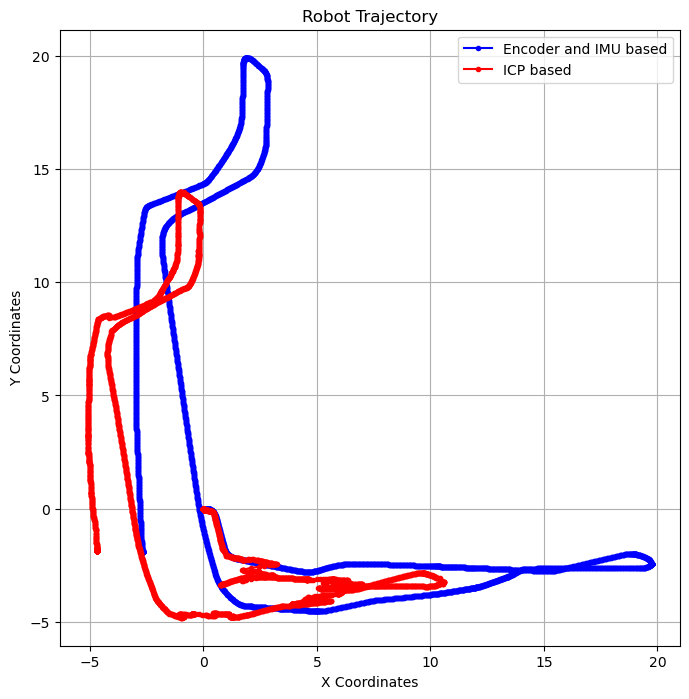

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(robot_state_arr[0,:], robot_state_arr[1,:], marker='.', linestyle='-', color='b')
plt.plot(LiDAR_robot_state_arr[0,:], LiDAR_robot_state_arr[1,:], marker='.', linestyle='-', color='r')
plt.title('Robot Trajectory')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.legend(['Encoder and IMU based', 'ICP based'])
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Trajectory_ICP based.png')
plt.show()

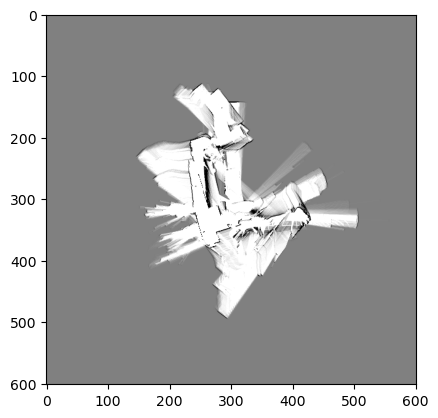

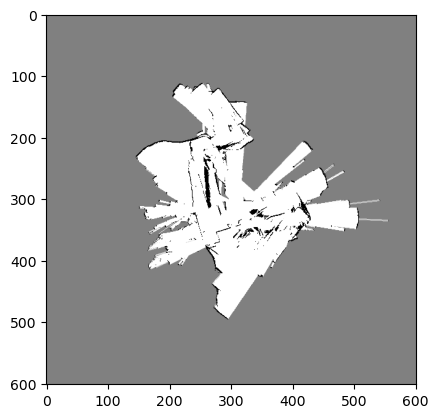

In [12]:
# init MAP
MAP = {}
MAP['res']   = 0.1 #meters
MAP['xmin']  = -30  #meters
MAP['ymin']  = -30
MAP['xmax']  =  30
MAP['ymax']  =  30 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
#MAP['map'] = np.zeros((MAP['sizex'], MAP['sizey'])) #DATA TYPE: char or int8

map = np.zeros((MAP['sizex'],MAP['sizey']))

for index in range(LiDAR_robot_state_arr.shape[1]): #(LiDAR_robot_state_arr.shape[1]):
    state, lidar_cor_robot = convert_lidar_robot_frame(index, LiDAR_robot_state_arr, encoder_stamps, lidar_stamps, lidar_position)
    xis = np.ceil((state[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((state[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    R = create_yaw_rotation(state[-1])
    lidar_cor_world = (R @ lidar_cor_robot)[:2] + np.array([[state[0]],[state[1]]])
    ex = np.ceil((lidar_cor_world[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    ey = np.ceil((lidar_cor_world[1] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    #map = np.zeros((MAP['sizex'],MAP['sizey']))
    for j in range(len(ex)):
        points = bresenham2D(xis, yis, ex[j], ey[j]) 
        map[MAP['sizey'] - points[1,:-1], points[0,:-1]] += log_trust_occupancy_grid
        map[MAP['sizey'] - points[1,-1], points[0,-1]] -= log_trust_occupancy_grid
    map[map>100] = 100
    map[map<-100] = -100

plt.imshow(map, cmap="gray")
plt.savefig(f'./Result/{dataset}_Occupancy_Map_Lidar.png')
plt.show()
plt.imshow(1 / (1 + np.exp(-map)), cmap="gray")
plt.savefig(f'./Result/{dataset}_Occupancy_Map_Lidar_Sigmoid.png')
plt.show()

# Occupancy and texture mapping

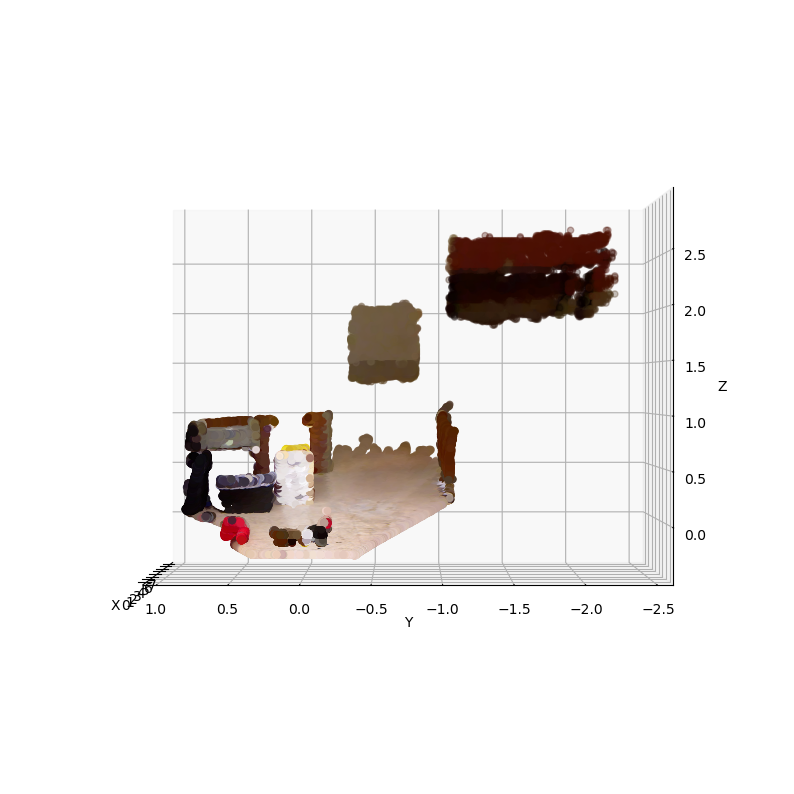

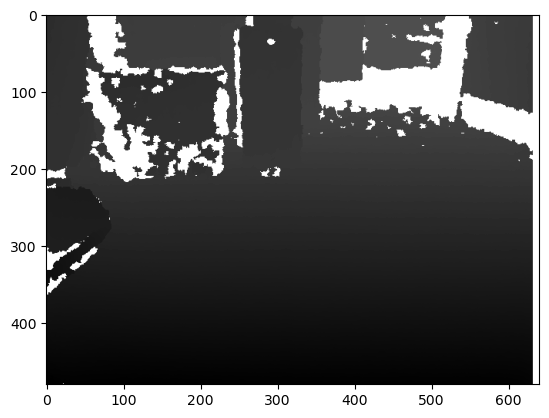

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "../data/dataRGBD/Disparity20/"
rgb_path = "../data/dataRGBD/RGB20/"

def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_-min_)
 
# load RGBD image
imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

# convert from disparity from uint16 to double
disparity = imd.astype(np.float32)

# get depth
dd = (-0.00304 * disparity + 3.31)
z = 1.03 / dd

# calculate u and v coordinates 
v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
#u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

# get 3D coordinates 
fx = 585.05108211
fy = 585.05108211
cx = 315.83800193
cy = 242.94140713
x = (u-cx) / fx * z
y = (v-cy) / fy * z

# calculate the location of each pixel in the RGB image
rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
rgbv = np.round((v * 526.37 + 16662.0)/fy)
valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

# display valid RGB pixels
fig = plt.figure(figsize=(10, 13.3))
ax = fig.add_subplot(projection='3d')
ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=180)
plt.show()

# display disparity image
plt.imshow(normalize(imd), cmap='gray')
plt.show()

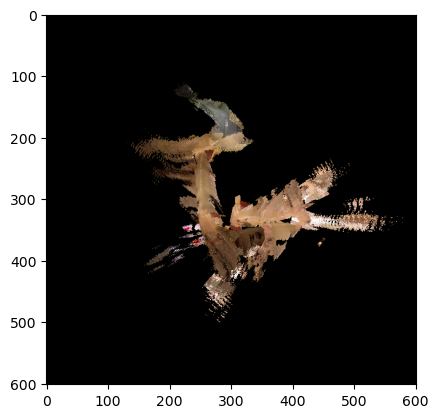

In [13]:
texture_map = {}
texture_map['res']   = 0.1 #meters
texture_map['xmin']  = -30  #meters
texture_map['ymin']  = -30
texture_map['xmax']  =  30
texture_map['ymax']  =  30 
texture_map['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
texture_map['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
texture_map['map'] = np.zeros((MAP['sizex'],MAP['sizey'],3)) #DATA TYPE: char or int8
flor_z_thrshld = 0 

disp_path = "../data/dataRGBD/Disparity"+ str(dataset) + "/"
rgb_path = "../data/dataRGBD/RGB" + str(dataset) + "/"

for image_counter in range(rgb_stamps.shape[0]):
# image_counter = 0
    imc = cv2.imread(rgb_path+'rgb'+str(dataset)+'_'+ str(image_counter+1) + '.png')[...,::-1] # (480 x 640 x 3)
    disparity_counter = find_nearest(disp_stamps, rgb_stamps[image_counter])
    imd = cv2.imread(disp_path+'disparity'+str(dataset)+'_'+str(disparity_counter+1)+'.png', cv2.IMREAD_UNCHANGED) # (480 x 640)
    # convert from disparity from uint16 to double
    disparity = imd.astype(np.float32)
    # get depth
    dd = (-0.00304 * disparity + 3.31)
    z = 1.03 / dd
    # calculate u and v coordinates 
    v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
    # get 3D coordinates 
    fx = 585.05108211
    fy = 585.05108211
    cx = 315.83800193
    cy = 242.94140713
    x = (u-cx) / fx * z
    y = (v-cy) / fy * z
    # calculate the location of each pixel in the RGB image
    rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
    rgbv = np.round((v * 526.37 + 16662.0)/fy)
    valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])
    x_c, y_c, z_c = z, -x, -y
    p_c = np.array([0.18, 0.005, 0.36])
    roll_c = 0
    pitch_c = 0.36
    yaw_c = 0.021
    R_c = euler2mat(roll_c, pitch_c, yaw_c, 'sxyz')
    x_r = x_c * R_c[0,0] + y_c * R_c[0,1] + z_c * R_c[0,2] + p_c[0]
    y_r = x_c * R_c[1,0] + y_c * R_c[1,1] + z_c * R_c[1,2] + p_c[1]
    z_r = x_c * R_c[2,0] + y_c * R_c[2,1] + z_c * R_c[2,2] + p_c[2]
    robot_counter = find_nearest(encoder_stamps, rgb_stamps[image_counter])
    robot_state = LiDAR_robot_state_arr[:, robot_counter]
    R_r = euler2mat(0, 0, robot_state[-1], 'sxyz')
    x_w = x_r * R_r[0,0] + y_r * R_r[0,1] + z_r * R_r[0,2] + robot_state[0]
    y_w = x_r * R_r[1,0] + y_r * R_r[1,1] + z_r * R_r[1,2] + robot_state[1]
    z_w = x_r * R_r[2,0] + y_r * R_r[2,1] + z_r * R_r[2,2] 
    
    x_cell = np.ceil((x_w - texture_map['xmin']) / MAP['res']).astype(np.int16)-1
    y_cell = np.ceil((y_w - texture_map['ymin']) / MAP['res']).astype(np.int16)-1
    floor = (z_w<flor_z_thrshld) & valid & (x_cell>0) & (x_cell <=texture_map['sizex']) & (y_cell>0) & (y_cell <=texture_map['sizex'])
    texture_map['map'][texture_map['sizey'] - y_cell[floor], x_cell[floor],:] = imc[rgbv[floor].astype(int),rgbu[floor].astype(int)] / 255.0

plt.imshow(texture_map['map'])
plt.savefig(f'./Result/{dataset}_Texture_Map_Lidar.png')
plt.show()

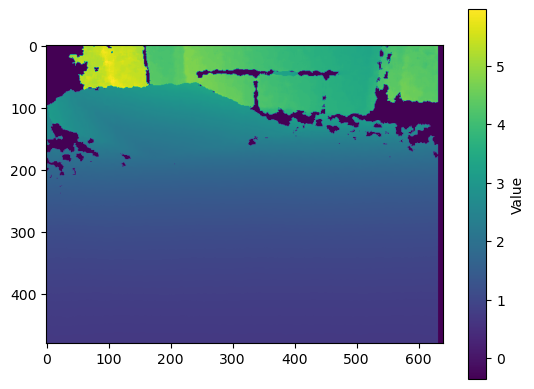

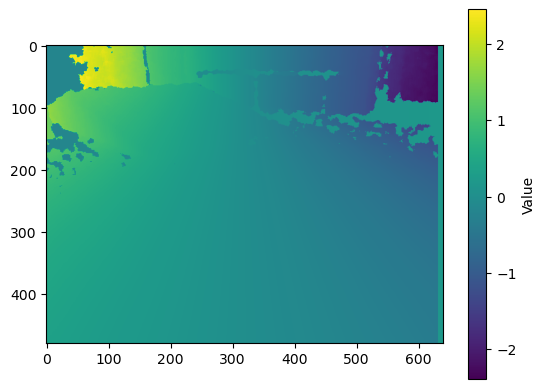

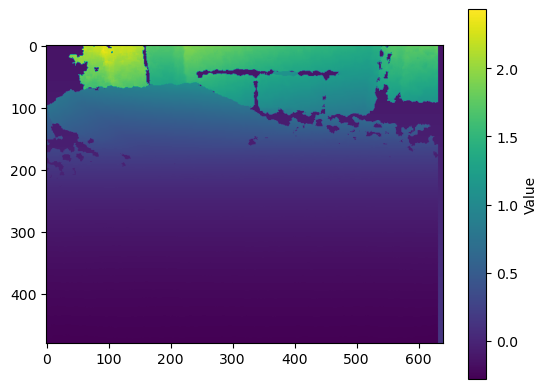

In [14]:
plt.imshow(x_c)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_x_c.png')
plt.show()
plt.imshow(y_c)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_y_c.png')
plt.show()
plt.imshow(z_c)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_z_c.png')
plt.show()

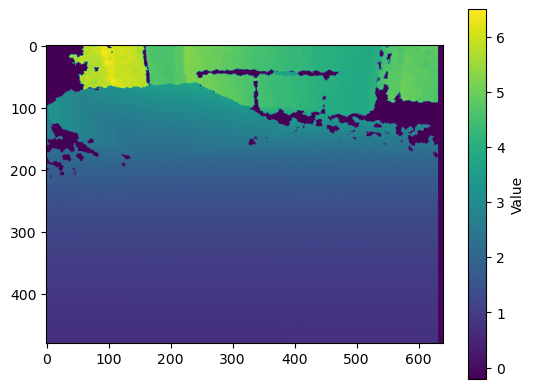

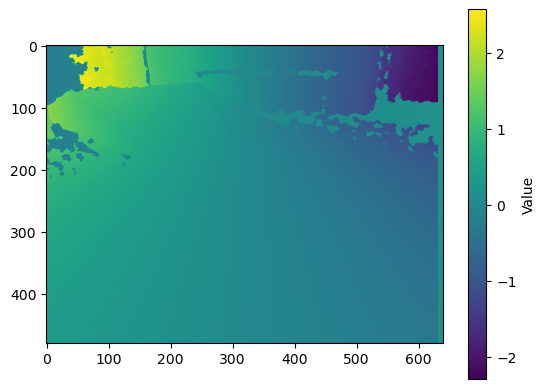

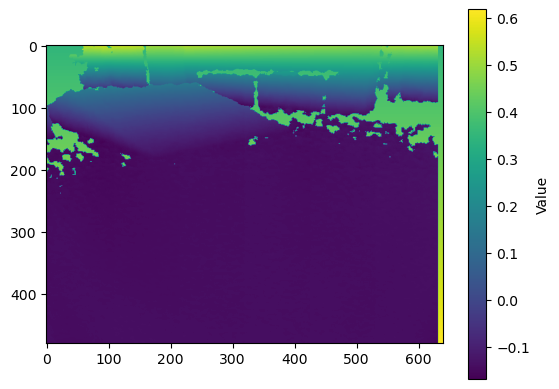

In [15]:
plt.imshow(x_r)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_x_r.png')
plt.show()
plt.imshow(y_r)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_y_r.png')
plt.show()
plt.imshow(z_r)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_z_r.png')
plt.show()

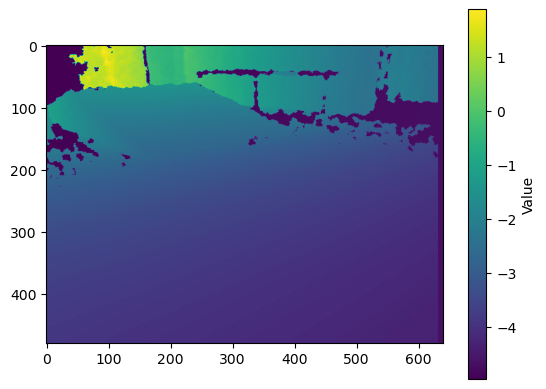

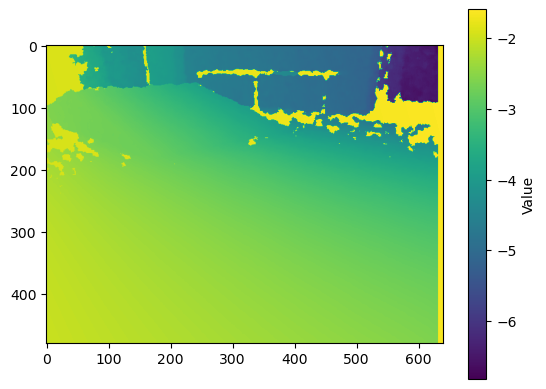

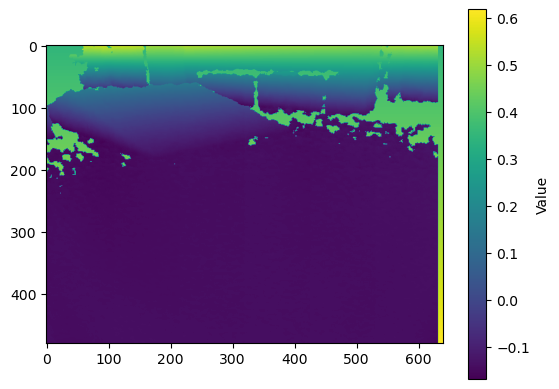

In [16]:
plt.imshow(x_w)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_x_w.png')
plt.show()
plt.imshow(y_w)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_y_w.png')
plt.show()
plt.imshow(z_w)
plt.colorbar(label='Value')  # Add color bar for reference
plt.savefig(f'./Result/{dataset}_z_w.png')
plt.show()

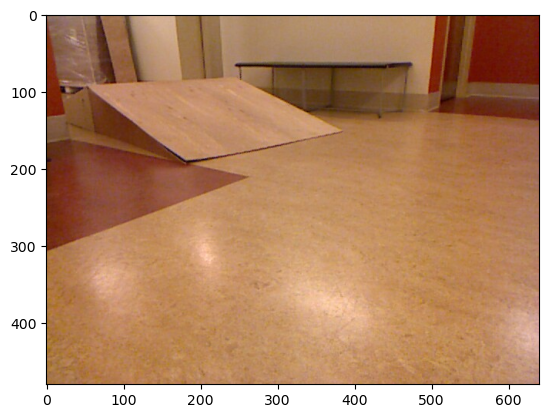

In [17]:
plt.imshow(imc)
plt.savefig(f'./Result/{dataset}_imc.png')
plt.show()

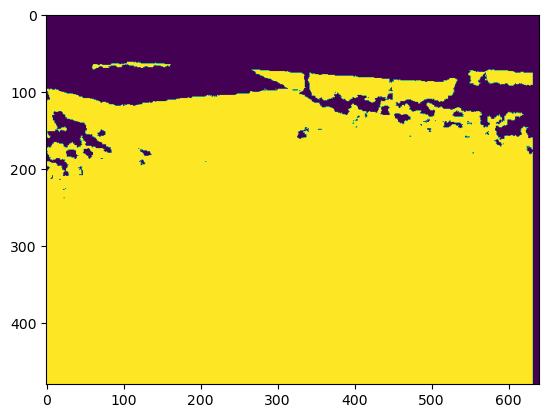

In [18]:
floor = (z_w<flor_z_thrshld) & valid
plt.imshow(floor)
plt.savefig(f'./Result/{dataset}_floor.png')
plt.show()

# Pose graph optimization and loop closure

In [19]:
loop_closure_freq = 10
graph = gtsam.NonlinearFactorGraph()
prior_model = gtsam.noiseModel.Diagonal.Sigmas((0.1, 0.1, 0.1))
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), prior_model))
odometry_model = gtsam.noiseModel.Diagonal.Sigmas((0.1, 0.1, 0.1))
Between = gtsam.BetweenFactorPose2
max_iter = LiDAR_robot_state_arr.shape[1]
for index in range(1, max_iter): # LiDAR_robot_state_arr.shape[1]):
    new_state = LiDAR_robot_state_arr[:,index]
    prev_state = LiDAR_robot_state_arr[:,index-1]
    relative_R = create_yaw_rotation(new_state[-1] - prev_state[-1])
    relative_P = create_yaw_rotation(prev_state[-1]).T @ np.array([[new_state[0] - prev_state[0]],
                                                                  [new_state[1] - prev_state[1]],
                                                                  [0]])
    graph.add(Between(index, index+1, gtsam.Pose2(relative_P[0,0], relative_P[1,0], new_state[-1] - prev_state[-1]), odometry_model))
    if index>=loop_closure_freq:
        new_state, new_lidar_cor_robot = convert_lidar_robot_frame(index, LiDAR_robot_state_arr, encoder_stamps, lidar_stamps, lidar_position)
        prev_state, prev_lidar_cor_robot = convert_lidar_robot_frame(index-loop_closure_freq, LiDAR_robot_state_arr, encoder_stamps, lidar_stamps, lidar_position)
        relative_R = create_yaw_rotation(new_state[-1] - prev_state[-1])
        relative_P = create_yaw_rotation(prev_state[-1]).T @ np.array([[new_state[0] - prev_state[0]],
                                                                  [new_state[1] - prev_state[1]],
                                                                  [0]])
        neigh = NearestNeighbors(n_neighbors=1)
        target = prev_lidar_cor_robot.T
        source = new_lidar_cor_robot.T
        neigh.fit(target)
        _, best_R, best_P = ipc_alg(source, target, neigh, R0=relative_R, P0=relative_P, max_iter=1000, tolerance=1e-6)
        relative_yaw = mat2euler(best_R, 'rzyx')[0]
        graph.add(Between(index-loop_closure_freq+1, index+1, gtsam.Pose2(best_P[0,0], best_P[1,0], relative_yaw), odometry_model))
        
#graph.print("\nFactor Graph:\n")
initial_estimate = gtsam.Values()
for index in range(0, max_iter):
    initial_estimate.insert(index+1, gtsam.Pose2(LiDAR_robot_state_arr[:,index]))
#initial_estimate.print("\nInitial Estimate:\n")
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate)
result = optimizer.optimize()
GTSAM_robot_state_arr = gtsam.utilities.extractPose2(result).T

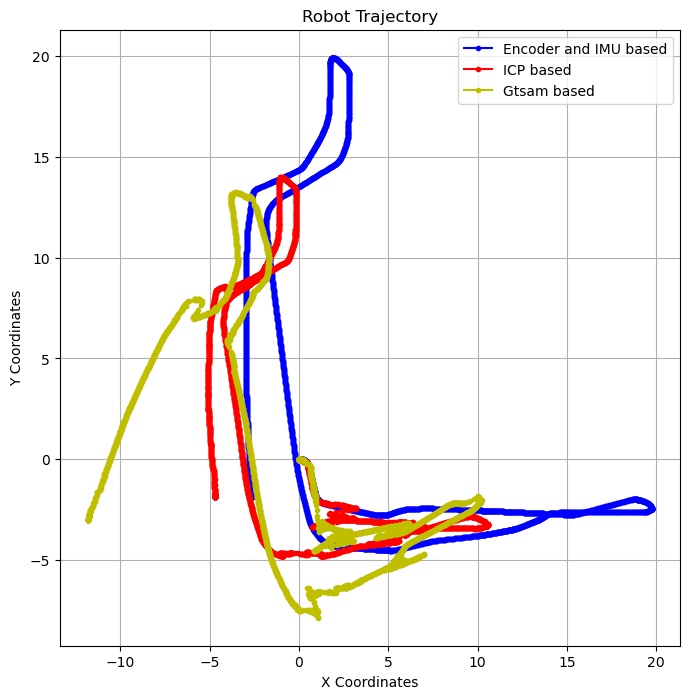

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(robot_state_arr[0,:], robot_state_arr[1,:], marker='.', linestyle='-', color='b')
plt.plot(LiDAR_robot_state_arr[0,:], LiDAR_robot_state_arr[1,:], marker='.', linestyle='-', color='r')
plt.plot(GTSAM_robot_state_arr[0,:], GTSAM_robot_state_arr[1,:], marker='.', linestyle='-', color='y')
plt.title('Robot Trajectory')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.legend(['Encoder and IMU based', 'ICP based', 'Gtsam based'])
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Trajectory_gtsam_based.png')

plt.show()

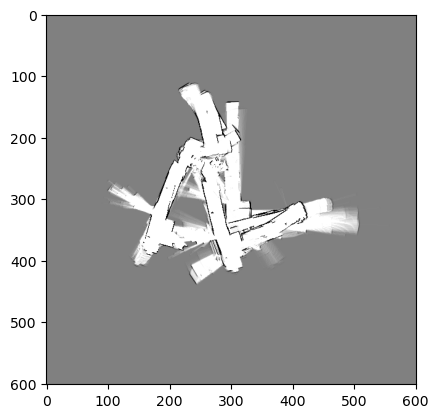

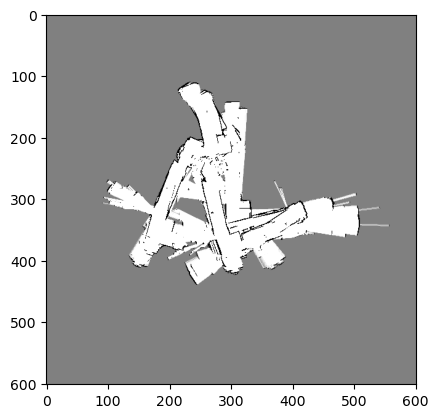

In [21]:
map = np.zeros((MAP['sizex'],MAP['sizey']))

for index in range(GTSAM_robot_state_arr.shape[1]): #(LiDAR_robot_state_arr.shape[1]):
    state, lidar_cor_robot = convert_lidar_robot_frame(index, GTSAM_robot_state_arr, encoder_stamps, lidar_stamps, s)
    xis = np.ceil((state[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1 # GTSAM_robot_state_arr
    yis = np.ceil((state[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    R = create_yaw_rotation(state[-1])
    lidar_cor_world = (R @ lidar_cor_robot)[:2] + np.array([[state[0]],[state[1]]])
    ex = np.ceil((lidar_cor_world[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    ey = np.ceil((lidar_cor_world[1] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    #map = np.zeros((MAP['sizex'],MAP['sizey']))
    for j in range(len(ex)):
        points = bresenham2D(xis, yis, ex[j], ey[j]) 
        map[MAP['sizey'] - points[1,:-1], points[0,:-1]] += log_trust_occupancy_grid
        map[MAP['sizey'] - points[1,-1], points[0,-1]] -= log_trust_occupancy_grid
    map[map>100] = 100
    map[map<-100] = -100

plt.imshow(map, cmap="gray")
plt.savefig(f'./Result/{dataset}_Occupancy_Map_gtsam.png')
plt.show()
plt.imshow(1 / (1 + np.exp(-map)), cmap="gray")
plt.savefig(f'./Result/{dataset}_Occupancy_Map_gtsam_Sigmoid.png')
plt.show()

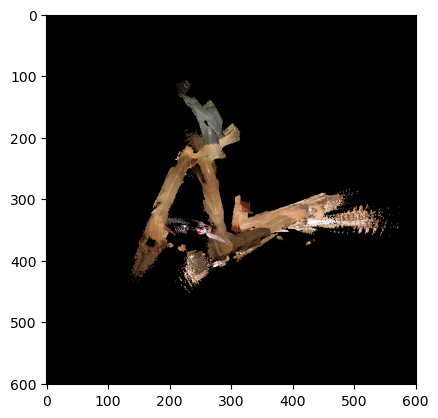

In [22]:
texture_map = {}
texture_map['res']   = 0.1 #meters
texture_map['xmin']  = -30  #meters
texture_map['ymin']  = -30
texture_map['xmax']  =  30
texture_map['ymax']  =  30 
texture_map['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
texture_map['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
texture_map['map'] = np.zeros((MAP['sizex'],MAP['sizey'],3)) #DATA TYPE: char or int8
texture_map['map'] = np.zeros((MAP['sizex'],MAP['sizey'],3)) #DATA TYPE: char or int8
flor_z_thrshld = 0 #- diameter / 2

disp_path = "../data/dataRGBD/Disparity"+ str(dataset) + "/"
rgb_path = "../data/dataRGBD/RGB" + str(dataset) + "/"

for image_counter in range(rgb_stamps.shape[0]):
# image_counter = 0
    imc = cv2.imread(rgb_path+'rgb'+str(dataset)+'_'+ str(image_counter+1) + '.png')[...,::-1] # (480 x 640 x 3)
    disparity_counter = find_nearest(disp_stamps, rgb_stamps[image_counter])
    imd = cv2.imread(disp_path+'disparity'+str(dataset)+'_'+str(disparity_counter+1)+'.png', cv2.IMREAD_UNCHANGED) # (480 x 640)
    # convert from disparity from uint16 to double
    disparity = imd.astype(np.float32)
    # get depth
    dd = (-0.00304 * disparity + 3.31)
    z = 1.03 / dd
    # calculate u and v coordinates 
    v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
    # get 3D coordinates 
    fx = 585.05108211
    fy = 585.05108211
    cx = 315.83800193
    cy = 242.94140713
    x = (u-cx) / fx * z
    y = (v-cy) / fy * z
    # calculate the location of each pixel in the RGB image
    rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
    rgbv = np.round((v * 526.37 + 16662.0)/fy)
    valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])
    x_c, y_c, z_c = z, -x, -y
    p_c = np.array([0.18, 0.005, 0.36])
    roll_c = 0
    pitch_c = 0.36
    yaw_c = 0.021
    R_c = euler2mat(roll_c, pitch_c, yaw_c, 'sxyz')
    x_r = x_c * R_c[0,0] + y_c * R_c[0,1] + z_c * R_c[0,2] + p_c[0]
    y_r = x_c * R_c[1,0] + y_c * R_c[1,1] + z_c * R_c[1,2] + p_c[1]
    z_r = x_c * R_c[2,0] + y_c * R_c[2,1] + z_c * R_c[2,2] + p_c[2]
    robot_counter = find_nearest(encoder_stamps, rgb_stamps[image_counter])
    robot_state = GTSAM_robot_state_arr[:, robot_counter]
    R_r = euler2mat(0, 0, robot_state[-1], 'sxyz')
    x_w = x_r * R_r[0,0] + y_r * R_r[0,1] + z_r * R_r[0,2] + robot_state[0]
    y_w = x_r * R_r[1,0] + y_r * R_r[1,1] + z_r * R_r[1,2] + robot_state[1]
    z_w = x_r * R_r[2,0] + y_r * R_r[2,1] + z_r * R_r[2,2] 
    
    x_cell = np.ceil((x_w - texture_map['xmin']) / MAP['res']).astype(np.int16)-1
    y_cell = np.ceil((y_w - texture_map['ymin']) / MAP['res']).astype(np.int16)-1
    floor = (z_w<flor_z_thrshld) & valid & (x_cell>0) & (x_cell <=texture_map['sizex']) & (y_cell>0) & (y_cell <=texture_map['sizex'])
    texture_map['map'][texture_map['sizey'] - y_cell[floor], x_cell[floor],:] = imc[rgbv[floor].astype(int),rgbu[floor].astype(int)] / 255.0

plt.imshow(texture_map['map'])
plt.savefig(f'./Result/{dataset}_Texture_Map_gtsam.png')
plt.show()